<a href="https://colab.research.google.com/github/ScottVinay/Visual_hand_sign_recognition/blob/master/CCTV_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<br>

***
***
# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; CCTV
***
***

<br>
<br>

**Abstract** &emsp;&emsp; In this work, we train a neural network on images that I recorded of my hand, to identify how many finger I am holding up - resulting in an almost 100% accuracy. This is then used for a localisation script, which finds an image of my hand in a larger image. This can be generalised to multiple pictures of hands in one image.

## Set-up

This notebook was run on Google Colab, due to the high processing power of its GPUs. The images, on the other hand, were gathered by the script `CCTV_gathering_data.ipynb`. This was run locally, since Google Colab has trouble accessing a webcam feed. If you wish to replicate this work and run it yourself, be sure to edit the `path` variable in both this file and the data gathering file to point to the same location on your local machine.

In [1]:
import numpy as np
from numpy import array as na
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
import cv2
from PIL import Image

from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Python scripts/Data Science/CCTV/'

from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from skimage.transform import resize as skresize

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We start by creating the convolutional model. We have a stack of conv layers to extract features, interspersed by max pooling to reduce the number of parameters of the network. We include a dropout to avoid overfitting (although it seems this isn't hugely necessary here), and then dense layers to combine our data into a single label.

In [2]:
imSize = 128

def createModel(model=None,reset=1):
    if type(model)==type(None):
        activ = 'relu'
        pool  = 2
        inputs = Input(name='inputs',shape=[imSize,imSize,3])
        layer = Conv2D(16,4,name='conv1',activation=activ)(inputs)
        layer = MaxPooling2D(pool,pool)(layer)
        layer = Conv2D(32,4,name='conv2',activation=activ)(layer)  
        layer = MaxPooling2D(pool,pool)(layer)
        layer = Conv2D(64,4,name='conv3',activation=activ)(layer)
        layer = MaxPooling2D(pool,pool)(layer)
        layer = Conv2D(128,4,name='conv4',activation=activ)(layer)
        layer = MaxPooling2D(pool,pool)(layer)
        layer = Dropout(0.5)(layer)
        layer = Flatten()(layer)
        layer = Dense(512,activation=activ)(layer)
        layer = Dense(5,activation='softmax')(layer)
        model = Model(inputs=inputs,outputs=layer)
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
    if reset:
        reset_weights(model)
    return model
  
# This is a function to reset our model, since compile doesn't do so.
def reset_weights(model):
    from tensorflow.keras.backend import get_session
    session = get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

model = createModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

The size of our dataset is rather modest. Therefore we augment it with the `ImageDataGenerator` function. This applies flips, shears, zooms and more to get more data from our limited set.

In [3]:
datagen_tr = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
datagen_cv = ImageDataGenerator(rescale=1./255)

gen_tr = datagen_tr.flow_from_directory(path+'datafiles/train',
                                        target_size=(imSize,imSize),
                                        #color_mode='grayscale',
                                        batch_size=10,
                                        shuffle=True,
                                        class_mode=model.loss[:model.loss.index('_')])
gen_cv = datagen_cv.flow_from_directory(path+'datafiles/cv',
                                        target_size=(imSize,imSize),
                                        #color_mode='grayscale',
                                        batch_size=10,
                                        shuffle=True,
                                        class_mode=model.loss[:model.loss.index('_')])

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path, 
                              save_weights_only=True,
                              verbose=False)

#!ls {checkpoint_dir}
#model.load_weights(checkpoint_path)

Found 1050 images belonging to 5 classes.
Found 145 images belonging to 5 classes.


## Training

In [0]:
gen_tr.reset()
gen_cv.reset()
model = createModel()
hist = model.fit_generator(gen_tr,
                           steps_per_epoch=40,
                           epochs=30,
                           validation_data=gen_cv,
                           validation_steps=7,
                           callbacks=[])

Epoch 1/30
105/105 [==============================] - 773s 7s/step - loss: 1.5699 - acc: 0.2467 - val_loss: 1.0636 - val_acc: 0.5586
Epoch 2/30
105/105 [==============================] - 7s 68ms/step - loss: 0.9548 - acc: 0.5533 - val_loss: 0.6603 - val_acc: 0.6828
Epoch 3/30
105/105 [==============================] - 8s 74ms/step - loss: 0.5456 - acc: 0.7448 - val_loss: 0.2132 - val_acc: 0.9379
Epoch 4/30
105/105 [==============================] - 8s 72ms/step - loss: 0.5509 - acc: 0.7476 - val_loss: 0.2480 - val_acc: 0.8621
Epoch 5/30
105/105 [==============================] - 8s 74ms/step - loss: 0.3367 - acc: 0.8667 - val_loss: 0.0658 - val_acc: 1.0000
Epoch 6/30
105/105 [==============================] - 8s 72ms/step - loss: 0.3361 - acc: 0.8762 - val_loss: 0.1021 - val_acc: 0.9586
Epoch 7/30
105/105 [==============================] - 8s 74ms/step - loss: 0.2003 - acc: 0.9171 - val_loss: 0.0313 - val_acc: 1.0000
Epoch 8/30
105/105 [==============================] - 8s 78ms/step - 

### Saving and loading

In [0]:
#model.save('keras_CCTV_model_03.h5')
model = load_model('keras_CCTV_model_03.h5')

We can see that the CNN has trained on these images fairly well. This is to be expected, since we started with a very clean dataset.

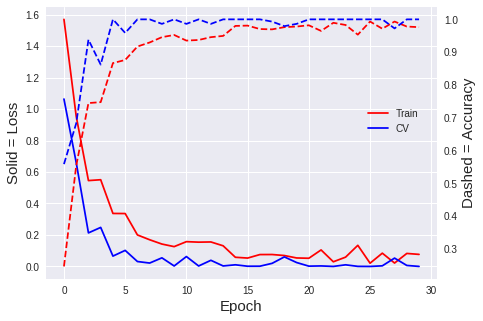

In [0]:
fig,ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()
ax1.plot(hist.history['loss'],'r',label='Train')
ax2.plot(hist.history['acc'],'r--')
ax1.plot(hist.history['val_loss'],'b',label='CV')
ax2.plot(hist.history['val_acc'],'b--')
ax1.legend(loc=3,bbox_to_anchor=(.8,.5))
ax1.set_xlabel('Epoch',fontsize=15)
ax1.set_ylabel('Solid = Loss',fontsize=15)
ax2.set_ylabel('Dashed = Accuracy',fontsize=15)
plt.grid(0)

## A sample output

We see that this gets the right image basically 100% of the time. This may be due to the fact that there wasn't a whole lot of variation in the input files. In the future, we will try introducing a larger variety of input files.

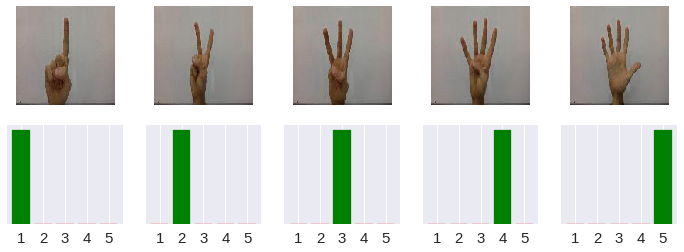

In [0]:
fig,axes = plt.subplots(ncols=5,nrows=2,figsize=(12,4))
[ax.set_xticks([]) for ax in axes[0,:]];
[ax.set_xticks([1,2,3,4,5]) for ax in axes[1,:]];
[[ax.set_yticks([]) for ax in axes[lev,:]] for lev in [0,1]];
for i in range(5):
    f = i+1
    im = loadImg(path+'datafiles/test/finger_{}/10.jpg'.format(f),0)
    axes[0,i].imshow(im[:,:,::-1])
    yp = model.predict(np.expand_dims(im,axis=0))
    bar = axes[1,i].bar([1,2,3,4,5],yp[0])
    [bar[i].set_color('r') for i in [0,1,2,3,4]]
    bar[i].set_color('g')
    axes[1,i].xaxis.set_tick_params(labelsize=15)

## Localisation

Here, we want to try to identify the hand in the image. We do this wil the sliding-window method. We take a lot of small sub-images, and different locations and zoom levels, and upsample them back to be 128 by 128. We then pass these through the model, and find the sub-image that best maximises the accuracy of the target classification.

Note that this is not a particularly efficient way of doing this, but it does allow for identification of multiple classes in the image. For a fixed class, it would be more computationally efficient to run a regression on the corner locations, but would take longer to train and write.

In [0]:
def loadImg(filename,forModel=1):
    im = Image.open(filename)
    im = np.array(im).astype('float32')/255
    if forModel: im = np.expand_dims(im, axis=0)
    return im

def subImg(img,zoom,number,index,newSize=None):
    '''
    Assume a square image.
    Number = number per side. Total number = this squared.
    Index = 2 coords = (x=0...n-1, y=0...n-1)
    '''
    if index[0]>=number or index[1]>=number:
        print('Error')
        return
    orSize = img.shape[1]
    if newSize==None:
        newSize=orSize
    
    smallSize = int(orSize/zoom)
    floatShift = orSize/number
    
    left, top = (floatShift*np.array(index)).astype(int)
    right, bottom = left+smallSize, top+smallSize
    
    newImg = img[left:right,top:bottom,:]
    resizedLayers = [skresize(newImg[:,:,i],(newSize,newSize)) for i in [0,1,2]]
    return np.stack(resizedLayers,axis=-1)

def levelWidth(orSize,zoom,level):
    size = orSize
    for i in range(level):
        size = int(size/zoom)
    return size

def fullSearch(img,model,targetFingers,number=10,zooms=[2,3,4],newSize=None):
    '''
    We use newSize if the image's input is not the same as the model's input.
    The sub-images are resized to be of the correct size.
    '''
    targetCat = targetFingers-1
    bestAcc,besti,bestj,bestZoom = 0,0,0,0
    for zoom in zooms:
        for i in range(number):
            for j in range(number):
                sub = subImg(img,zoom,number,(i,j),newSize)
                yp = model.predict(np.expand_dims(sub, axis=0))
                acc = yp[0][targetCat]
                if acc>bestAcc:
                    bestAcc = acc
                    besti = i
                    bestj = j
                    bestZoom = zoom
    smallSize = int(img.shape[1]/bestZoom)
    floatShift = img.shape[1]/number
    
    left, top = (floatShift*np.array([besti,bestj])).astype(int)
    right, bottom = left+smallSize, top+smallSize
    return left,top,right,bottom
    
def plotBoundingBox(ax,left,top,right,bottom,col='g'):
    ax.plot([left,right],[top,top],col,linewidth=8)
    ax.plot([right,right],[top,bottom],col,linewidth=8)
    ax.plot([right,left],[bottom,bottom],col,linewidth=8)
    ax.plot([left,left],[bottom,top],col,linewidth=8)
    return

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


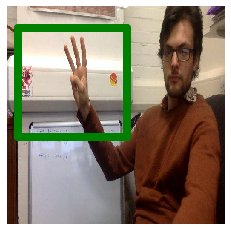

In [39]:
im = loadImg(path+'singleShots/7.jpg',0)
fig,ax = plt.subplots()
ax.imshow(im[:,:,::-1])
ax.set_xticks([]);
ax.set_yticks([]);
plotBoundingBox(ax,*fullSearch(im,model,3,20,np.arange(1.5,5,0.5),128),'g')

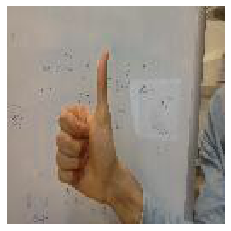

In [0]:
im = loadImg(path+'singleShots/5.jpg',0);fig,ax = plt.subplots()
ax.imshow(im[:,:,::-1]);ax.set_xticks([]);ax.set_yticks([]);

Thanks for reading

